In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
%matplotlib inline

In [ ]:
#To summarize, I used a completely unsupervised approach to allow the clustering algorithm to identify
#groups on its own, using all of the features. The clusters mostly rank ordered by overall finishing rank of the
#runner, with age and gender showing significant differences between clusters (in addition to the obvious time and
#pace differences which primarily dictated cluster assignment due to high prevalence of time variables in the 
#feature space. Aside from the affinity propagation model, which predicted 49 different clusters even with high damping,
#the mean shift, k means, and spectral clustering all produced similar clusters even on small samples and repeated tests)

#A future look at this assignment could use the cluster assignment as a feature in a supervised model, as this is 
#common practice in industry. You could also compare each cluster to a "ground truth" where you could create a binary
#indicator for top 1,5,10, x% and determine how well the cluster assigment align with the overall race ranks. But due to 
#the fact that most of the variables used in this clustering analysis are time-based, the clusters will obviously have a very
#high correlation with finishing time, so this exercise is not fruitful. 

#Overall, the K-means and spectral clustering performed the best for this dataset, as they produced the most reproducible
#clusters using small samples, and had respectably high silhouette scores of ~50%. Affinity propagation had stable clusters
#as well, and a slightly higher silhouette score, but 45-50 clusters (even with heavy damping), which is probably too
#complicated for us to use. It is not intuitive to define 50 different types of runners, after all. #Mean-shift was useful
#in helping us determine a stable number of clusters to define for other algorithms like k-means and spectral clustering, 
#but itself was actually not very stable/reproducible.

In [373]:
df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\boston_marathon_results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [374]:
#Convert some categorical data into binary data
country_dummies = pd.DataFrame(pd.get_dummies(df['country']))
#US is ~85% of the dataset... so why don't we do states instead
state_dummies = pd.DataFrame(pd.get_dummies(df['state']))

In [376]:
#Binarize gender. Assign numbers to countries. Remove name, bib, state, city, country
df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
df = df.drop(['name', 'bib', 'ctz', 'state', 'city', 'country', 'gender'], axis = 1)

In [377]:
df.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_bin
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,1
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,0
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,1
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,0
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,1


In [378]:
df = df.merge(right = state_dummies, left_index = True, right_index = True)

In [379]:
df.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,YT
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,...,0,0,0,0,0,0,0,0,0,0
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,...,0,0,0,0,0,0,0,0,0,0
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,...,0,0,0,0,0,0,0,0,0,0
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,...,0,0,0,0,0,0,0,0,0,0
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,...,0,0,0,0,0,0,0,0,0,0


In [380]:
#Some runners have a '-' for certain fields. Replace with np.nan and drop them
for col in range(len(df.columns)):
    df[df.columns[col]] = df[df.columns[col]].apply(lambda x: str(x).strip()).replace('-', np.nan)
    df[df.columns[col]] = df[df.columns[col]].apply(lambda x: float(x))

In [381]:
print(len(df))
df = df.dropna()
print(len(df))

31984
31649


In [382]:
df.columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k', 'gender_bin',
       'AA', 'AB', 'AE', 'AK', 'AL', 'AP', 'AR', 'AZ', 'BC', 'CA', 'CO', 'CT',
       'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MB', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NB', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NL', 'NM', 'NS', 'NT', 'NV', 'NY', 'OH', 'OK',
       'ON', 'OR', 'PA', 'PE', 'PR', 'QC', 'RI', 'SC', 'SD', 'SK', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'YT'],
      dtype='object')

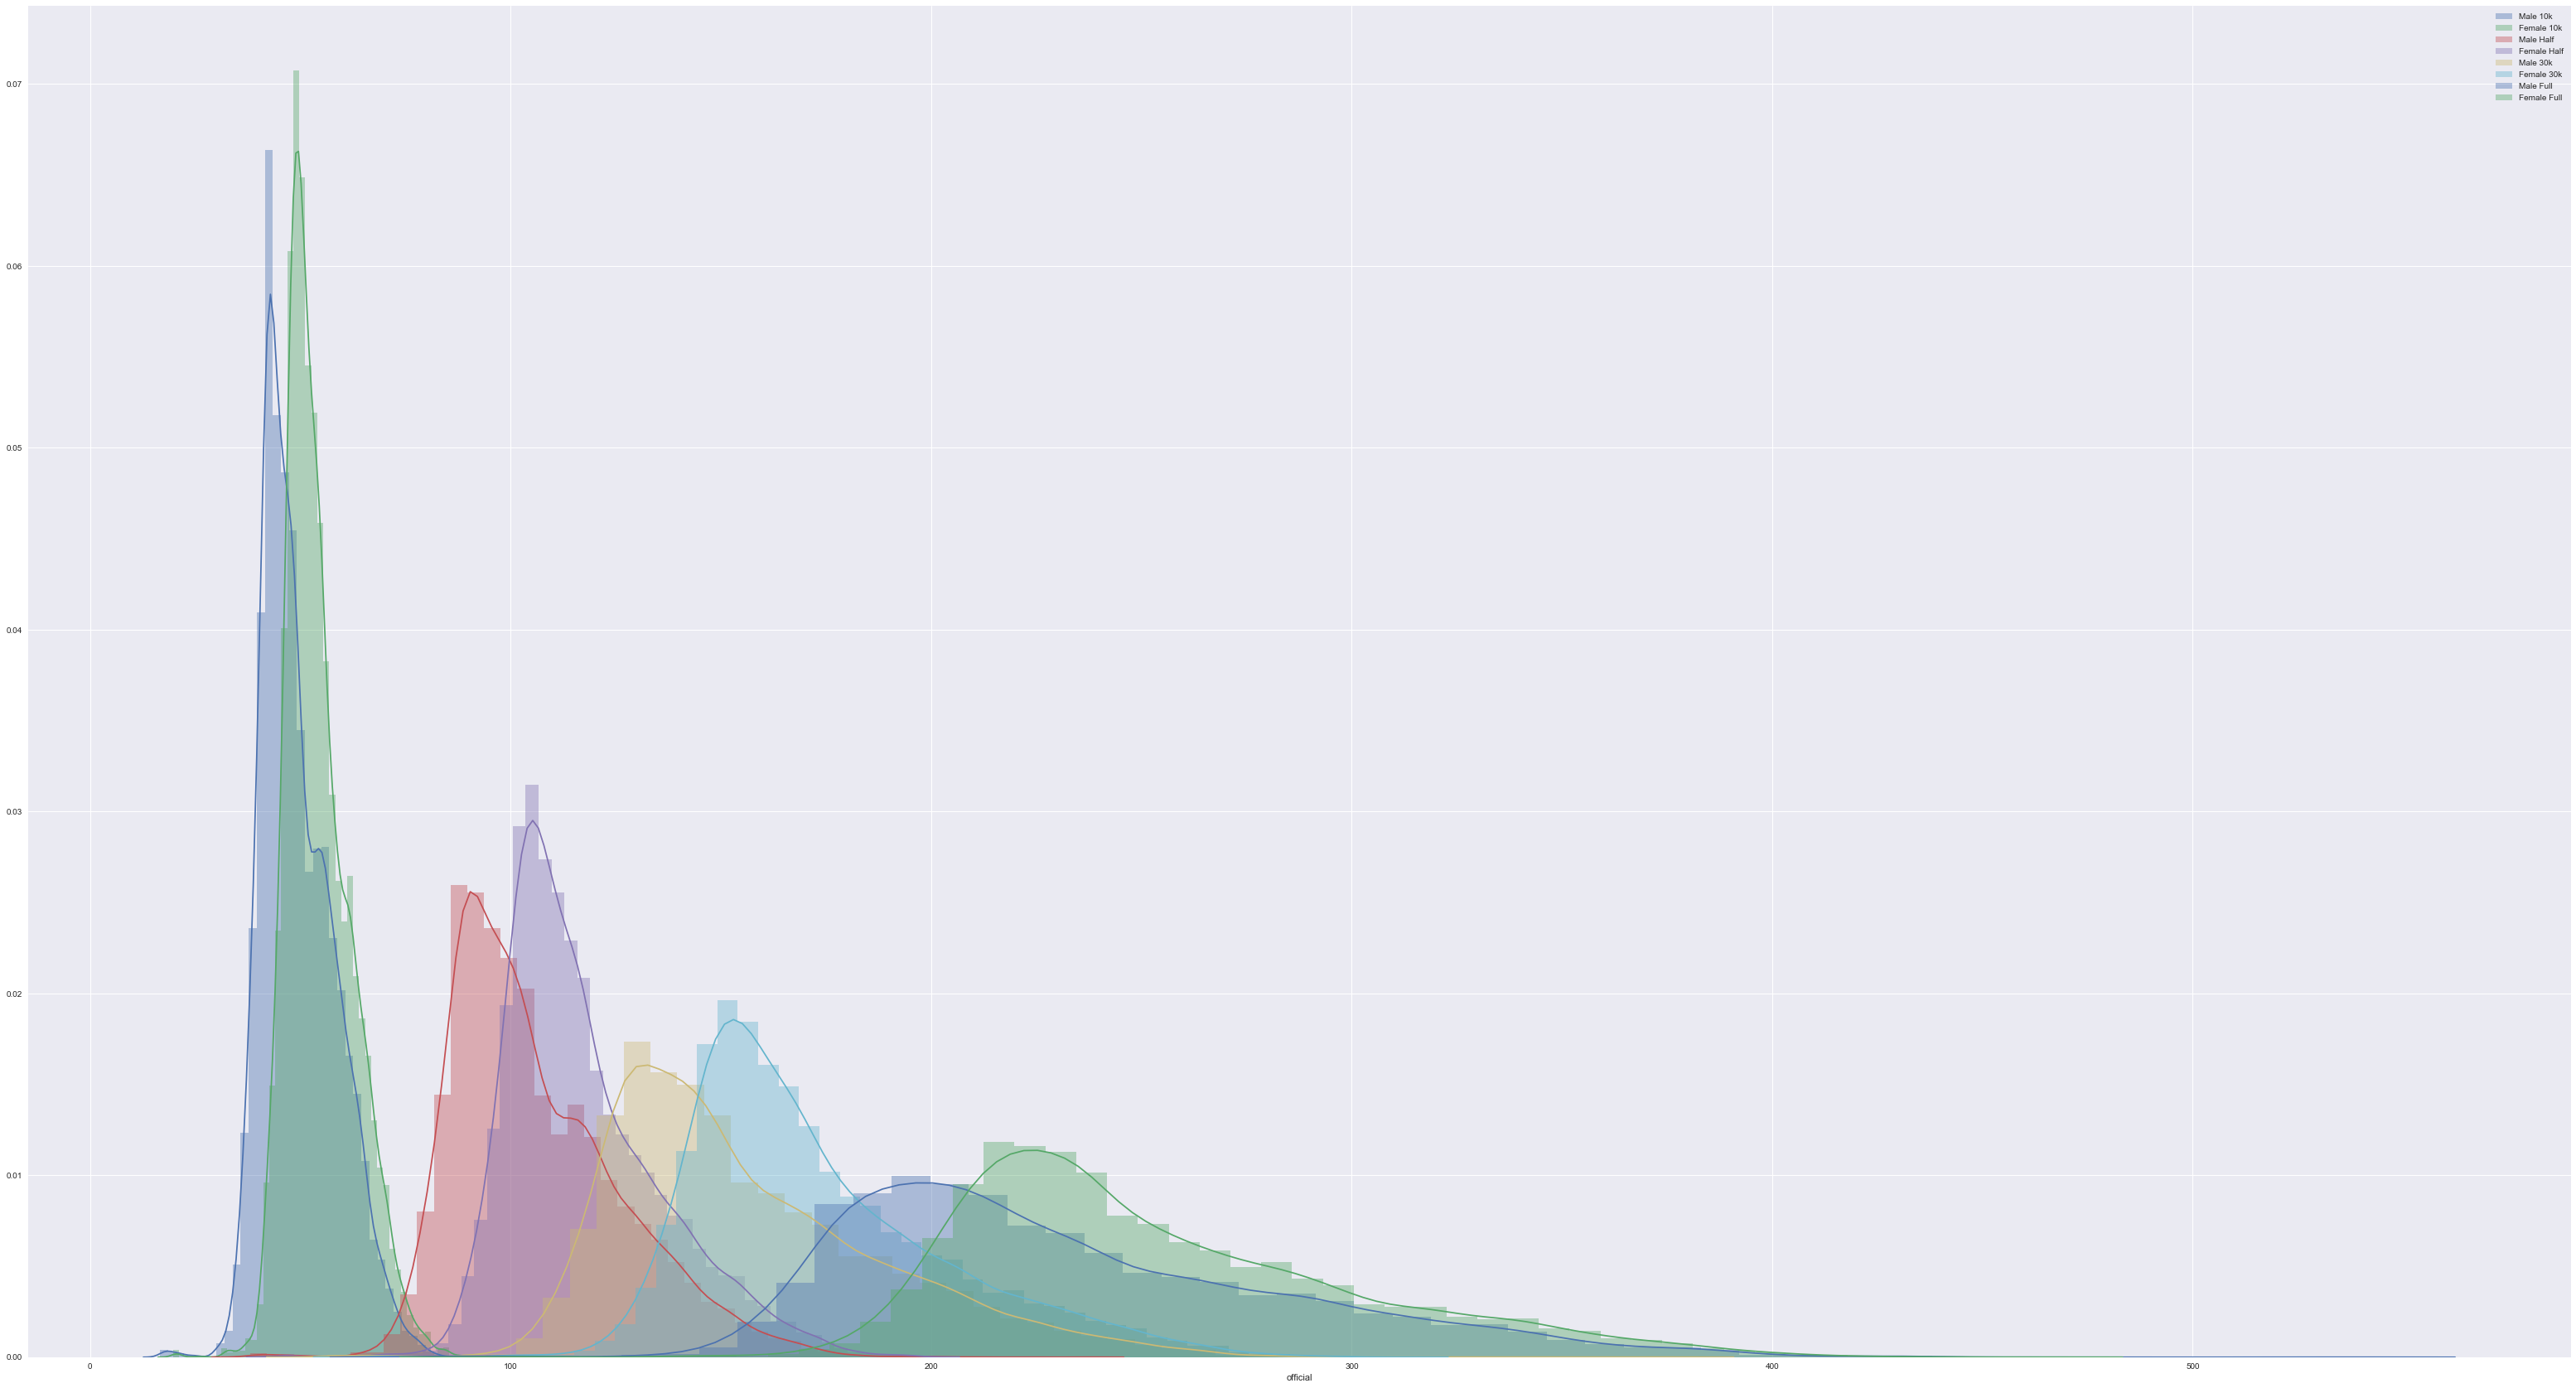

In [444]:
#Start with some data exploration and visualization
plt.figure(figsize=(55,30))
fig = sns.distplot(df[df['gender_bin'] == 1]['10k'], label = "Male 10k")
fig = sns.distplot(df[df['gender_bin'] == 0]['10k'], label = "Female 10k")
fig = sns.distplot(df[df['gender_bin'] == 1]['half'], label = "Male Half")
fig = sns.distplot(df[df['gender_bin'] == 0]['half'], label = "Female Half")
fig = sns.distplot(df[df['gender_bin'] == 1]['30k'], label = "Male 30k")
fig = sns.distplot(df[df['gender_bin'] == 0]['30k'], label = "Female 30k")
fig = sns.distplot(df[df['gender_bin'] == 1]['official'], label = "Male Full")
fig = sns.distplot(df[df['gender_bin'] == 0]['official'], label = "Female Full")
fig.legend()
#Tails become fatter as race progresses. Males slightly faster than females.

In [413]:
df.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,YT
count,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,...,31649.000000,31649.000000,31649.000000,31649.000000,31649.000000,31649.00000,31649.000000,31649.000000,31649.000000,31649.000000
mean,51.629039,1922.747291,133.581175,42.385067,241.952383,8002.921988,196.033373,15833.958924,9.236463,163.894883,...,0.008057,0.031217,0.013555,0.022402,0.004455,0.01880,0.013555,0.001769,0.000695,0.000158
std,8.710102,1704.843679,25.571480,11.299795,50.842552,4733.255987,40.775036,9182.223743,1.939150,32.889354,...,0.089401,0.173908,0.115636,0.147989,0.066599,0.13582,0.115636,0.042028,0.026356,0.012568
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,45.370000,607.000000,115.430000,33.000000,205.300000,3940.000000,166.950000,7880.000000,7.830000,140.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,50.280000,1418.000000,128.850000,42.000000,231.980000,7919.000000,187.850000,15829.000000,8.850000,157.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,57.000000,2601.000000,147.700000,50.000000,272.200000,11893.000000,219.370000,23785.000000,10.380000,182.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


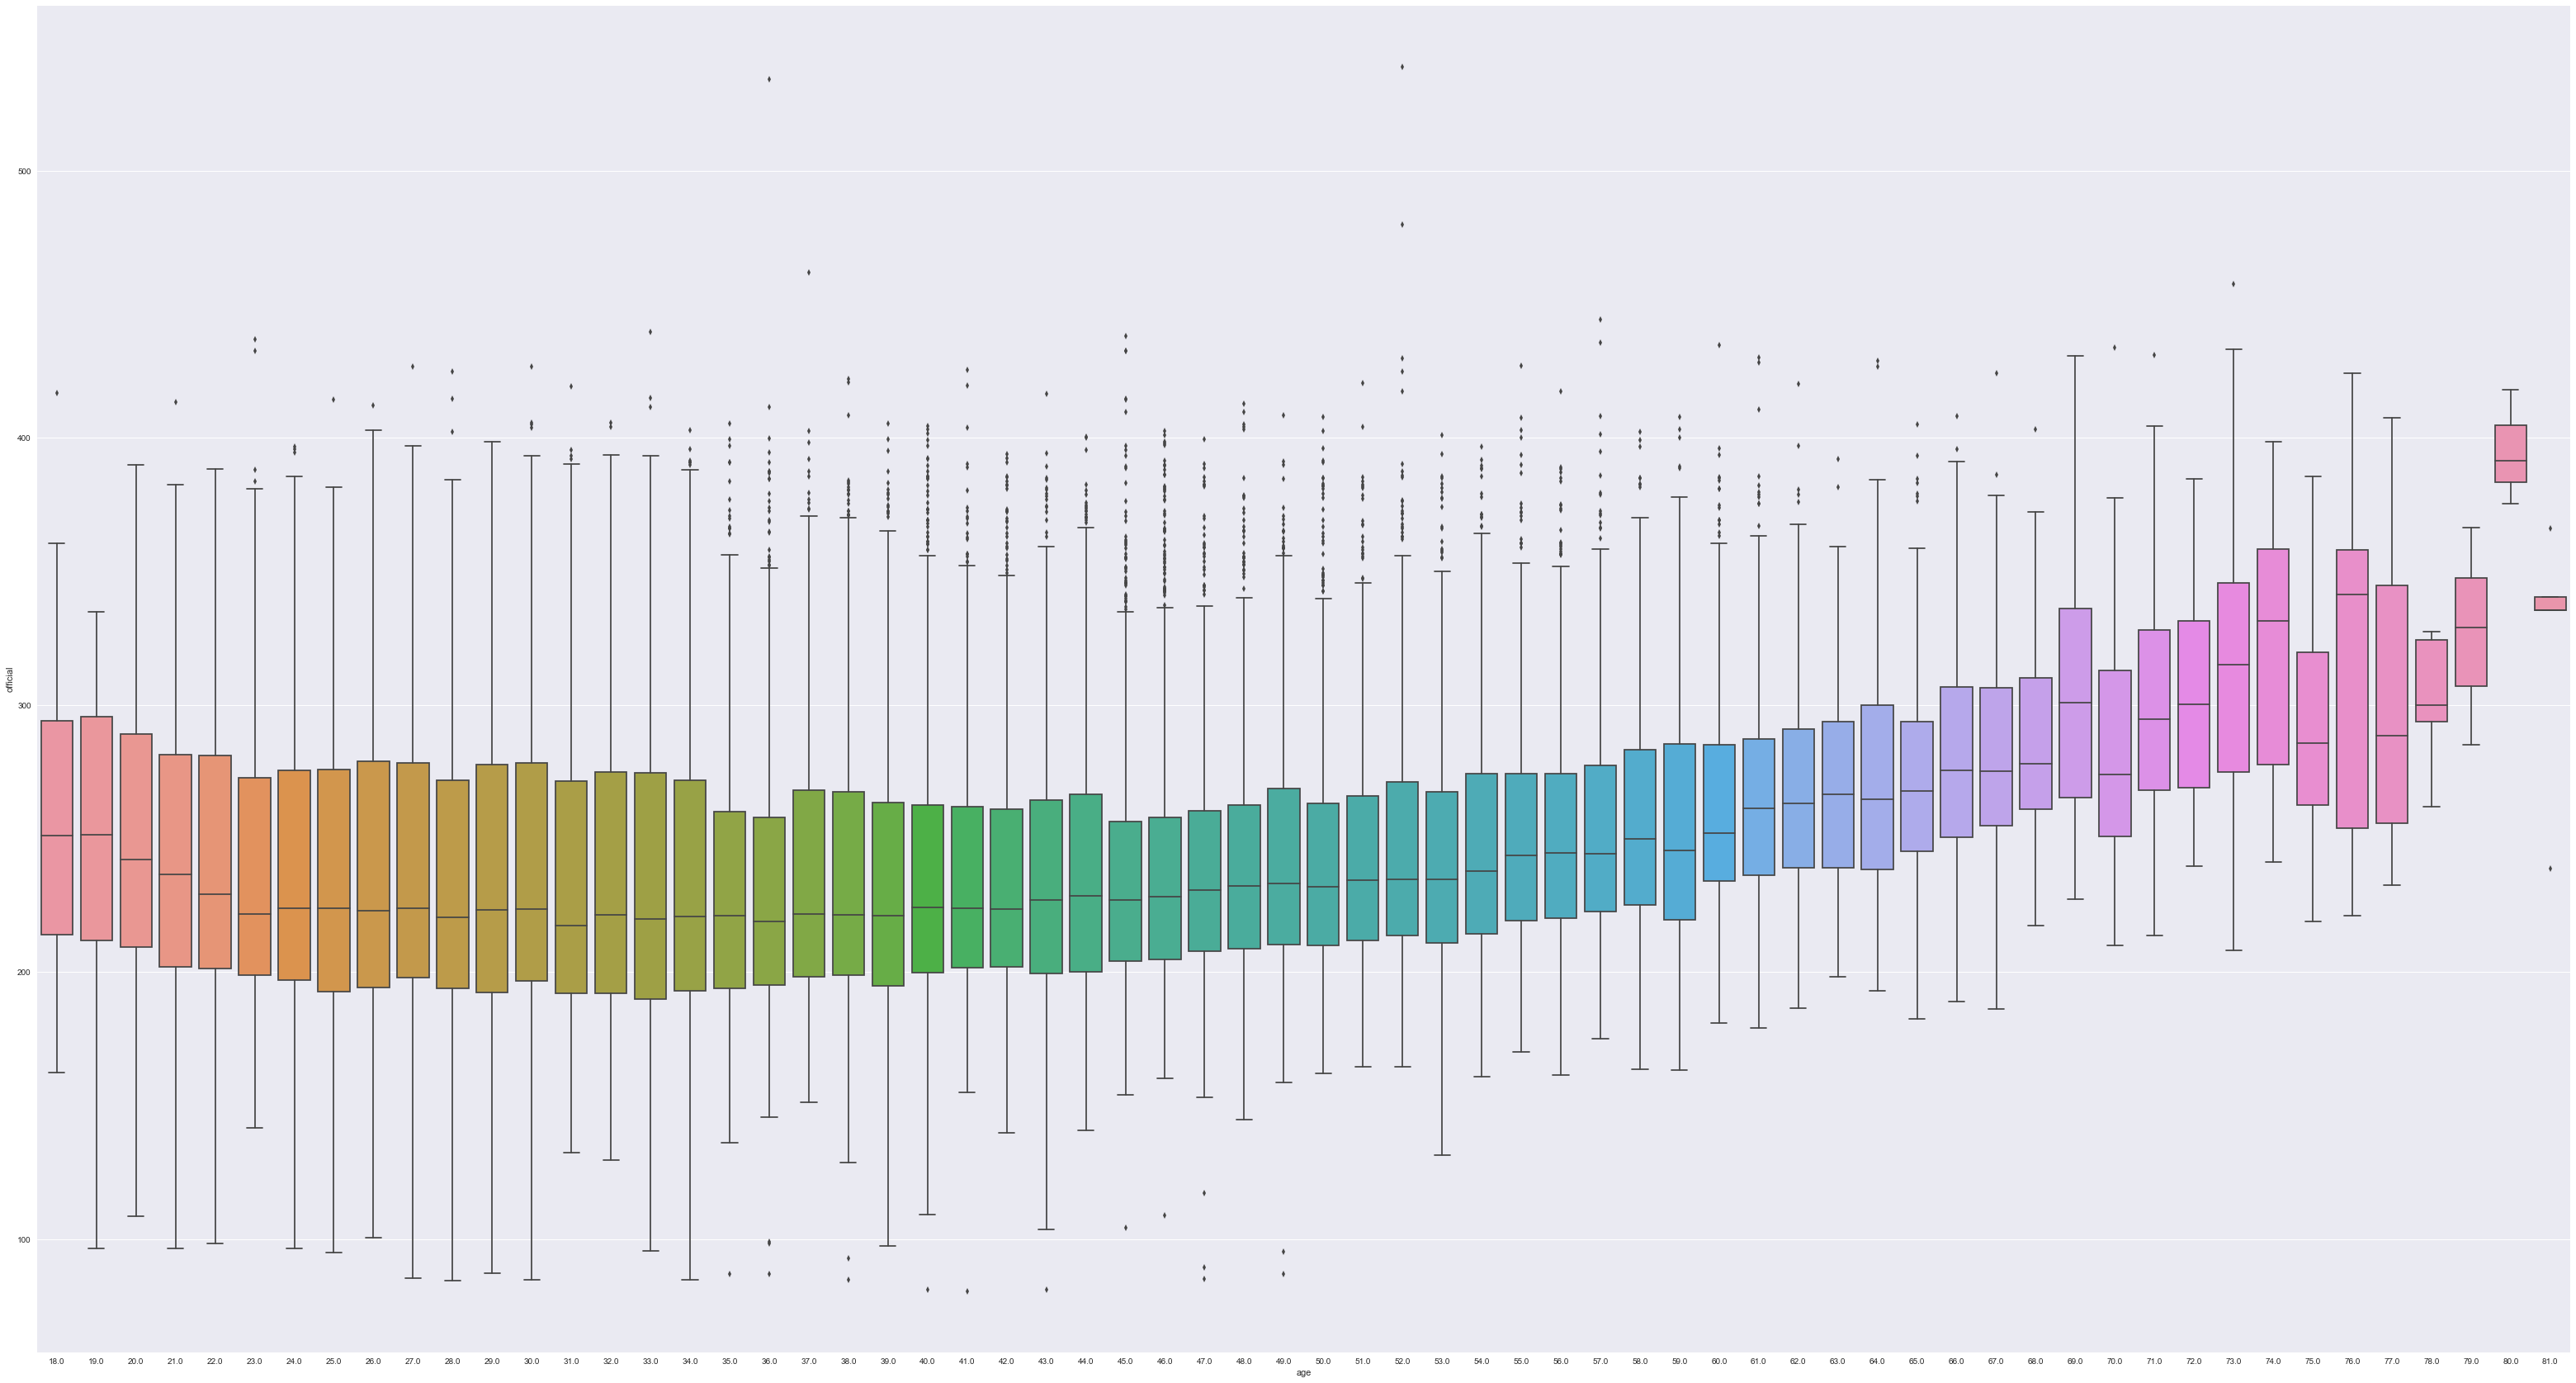

In [426]:
plt.figure(figsize=(55,30))
sns.boxplot(x = df['age'], y = df['official'])

#As expected, the relationship between age and race time is positively correlated after the age of ~30. It is also 
#NEGATIVELY correlated with age prior to age ~22, where runners have yet to hit their athletic primes

In [428]:
X = normalize(df)

Number of estimated clusters: 4


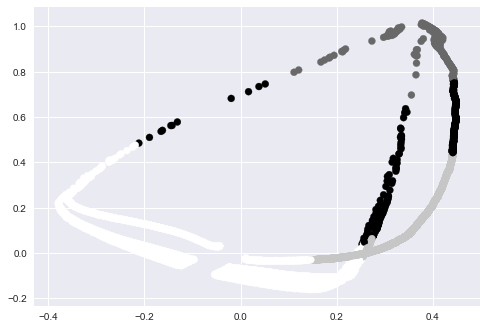

In [17]:
#We don't know how many clusters to expect.. so let's use Mean Shift clustering to begin

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
X_train, X_test = train_test_split(
    X,
    test_size=0.90,
    random_state=42)


##Trial #2 - let's just use the whole sample to train

X_train = X

from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

X_traindf = pd.DataFrame(X_train)

#Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

#Append Labels to the PCA reduced dataset
X_pca['Labels'] = labels

#Plot

plt.scatter(X_pca[0], X_pca[1], c = labels)

In [498]:
import itertools
c = list(itertools.product(labels))
counts = [[x, c.count(x)] for x in set(labels)]
print(counts)

[[0, 27804], [1, 3375], [2, 180], [3, 290]]


In [501]:
#Let's test the silhouette coefficient:

from sklearn import metrics
from sklearn.metrics import pairwise_distances

print(metrics.silhouette_score(X_train, labels, metric='euclidean'))

#Here, we used the full dataset to train, so we don't have multiple silhouette coefficients to compare how stable they are.
#We can remedy this in the future by using < 100% test sets. 

#For now, let's use this number and compare to the silhouette coefficients of our other clustering algorithms.

###### Actually, silhouette score fails due to memory issues. So let's try again with a smaller sample size

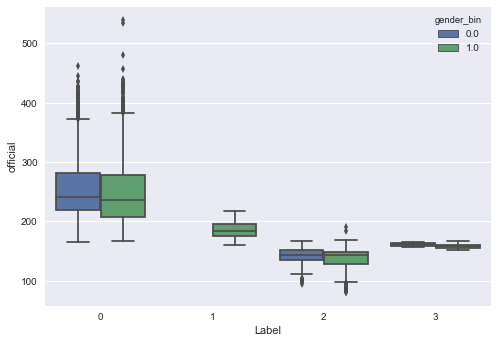

In [478]:
#Ok... so we have 4 groups.. what are they like? Let's plot average 'overall' time by group and see how it looks
import seaborn as sns
sns.boxplot(x = df['Label'], y = df['official'], hue = df['gender_bin'])

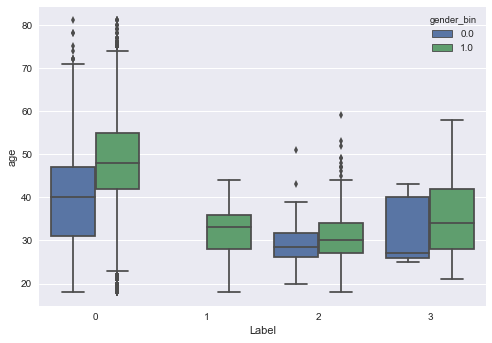

In [436]:
sns.boxplot(x = df['Label'], y = df['age'], hue = df['gender_bin'])

In [437]:
df[['gender_bin', 'age', 'overall']].groupby(df['Label']).mean()

,gender_bin,age,overall
Label,,,
0,0.492159,43.787369,17557.007301
1,1.000000,32.037333,3814.831407
2,0.811111,31.333333,53.983333
3,0.962069,35.224138,307.455172


In [440]:
df[['gender_bin', 'age', 'overall', 'official']].groupby(df['Label']).describe()

gender_bin           age       overall      official
Label                                                              
0     count  27804.000000  27804.000000  27804.000000  27804.000000
      mean       0.492159     43.787369  17557.007301    250.346870
      std        0.499948     11.167886   8384.390004     48.074378
      min        0.000000     18.000000    618.000000    165.480000
      25%        0.000000     36.000000  10680.750000    214.515000
      50%        0.000000     44.000000  17757.500000    238.750000
      75%        1.000000     51.000000  24753.250000    279.670000
      max        1.000000     81.000000  31931.000000    538.880000
1     count   3375.000000   3375.000000   3375.000000   3375.000000
      mean       1.000000     32.037333   3814.831407    185.723502
      std        0.000000      5.154210   2932.442822     14.446311
      min        1.000000     18.000000    338.000000    159.900000
      25%        1.000000     28.000000   1458.000000    174.780000
      50%        1.000000     33.000000   2958.000000    183.620000
      75%        1.000000     36.000000   5456.000000    195.790000
      max        1.000000     44.000000  11800.000000    218.030000
2     count    180.000000    180.000000    180.000000    180.000000
      mean       0.811111     31.333333     53.983333    133.816667
      std        0.392512      7.081331     38.375457     23.165719
      min        0.000000     18.000000      1.000000     80.600000
      25%        1.000000     27.000000     23.000000    128.755000
      50%        1.000000     30.000000     45.500000    143.450000
      75%        1.000000     34.000000     82.250000    149.347500
      max        1.000000     59.000000    184.000000    191.330000
3     count    290.000000    290.000000    290.000000    290.000000
      mean       0.962069     35.224138    307.455172    158.630276
      std        0.191360      8.690852    142.852913      3.660964
      min        0.000000     21.000000    122.000000    152.080000
      25%        1.000000     27.000000    200.250000    155.655000
      50%        1.000000     33.500000    272.500000    158.450000
      75%        1.000000     42.000000    373.000000    160.930000
      max        1.000000     58.000000    693.000000    166.720000

In [441]:
df.groupby(df['Label']).mean()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,...,TN,TX,UT,VA,VT,WA,WI,WV,WY,YT
Label,,,,,,,,,,,,,,,,,,,,,
0,53.164152,1956.038052,137.908476,43.787369,250.346870,8709.578981,202.786198,17557.007301,9.556623,169.387641,...,0.007984,0.030751,0.013487,0.021004,0.004424,0.018702,0.013379,0.001583,0.000683,0.000144
1,41.448566,1904.061333,104.557176,32.037333,185.723502,3270.740444,150.615730,3814.831407,7.091988,126.969298,...,0.008000,0.037333,0.014222,0.032593,0.004741,0.019852,0.015111,0.003556,0.000889,0.000296
2,29.805111,32.794444,76.732444,31.333333,133.816667,37.250000,110.381667,53.983333,5.111667,93.325333,...,0.005556,0.000000,0.016667,0.011111,0.000000,0.011111,0.011111,0.000000,0.000000,0.000000
3,36.474310,121.506897,91.762172,35.224138,158.630276,268.586207,130.330897,307.455172,6.058379,110.811207,...,0.017241,0.024138,0.010345,0.044828,0.006897,0.020690,0.013793,0.000000,0.000000,0.000000


In [ ]:
#Seems that the algorithm is clustering around race time (since many time features: 5k, 10k, half, 20k, 30k, 40k, official
#constitute many of the features in the feature space.

#Age and gender are important variables in the clusters as well

In [264]:
df.columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k', 'gender_bin',
       'AA', 'AB', 'AE', 'AK', 'AL', 'AP', 'AR', 'AZ', 'BC', 'CA', 'CO', 'CT',
       'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MB', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NB', 'NC',
       'ND', 'NE', 'NH', 'NJ', 'NL', 'NM', 'NS', 'NT', 'NV', 'NY', 'OH', 'OK',
       'ON', 'OR', 'PA', 'PE', 'PR', 'QC', 'RI', 'SC', 'SD', 'SK', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'YT', 'Label'],
      dtype='object')

Number of estimated clusters: 4
[[0, 27804], [1, 3375], [2, 180], [3, 290]]


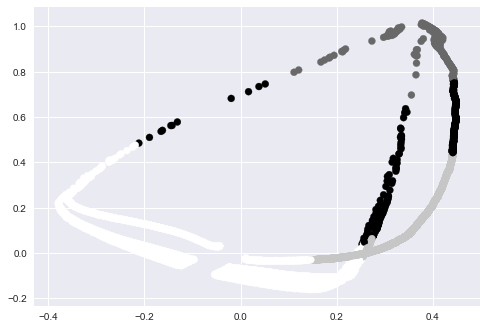

In [12]:
#Try clustering again without state dummy vars. Too many dimensions will obscure relevant distance data...

df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\boston_marathon_results.csv')

#Binarize gender. Assign numbers to countries. Remove name, bib, state, city, country
df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
df = df.drop(['name', 'bib', 'ctz', 'state', 'city', 'country', 'gender'], axis = 1)

#Some runners have a '-' for certain fields. Replace with np.nan and drop them
for col in range(len(df.columns)):
    df[df.columns[col]] = df[df.columns[col]].apply(lambda x: str(x).strip()).replace('-', np.nan)
    df[df.columns[col]] = df[df.columns[col]].apply(lambda x: float(x))
    
#Drop NaNs
df = df.dropna()

#Normalize the data for clustering
X = normalize(df)

#We don't know how many clusters to expect.. so let's use Mean Shift clustering to begin

from sklearn.model_selection import train_test_split

#Divide into training and test sets.
#X_train, X_test = train_test_split(
#    X,
#    test_size=0.25,
#    random_state=42)


##Trial #2 - let's just use the whole sample to train

X_train = X

from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

X_traindf = pd.DataFrame(X_train)

#Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

#Append Labels to the PCA reduced dataset
X_pca['Labels'] = labels

#Plot

plt.scatter(X_pca[0], X_pca[1], c = labels)

import itertools
c = list(itertools.product(labels))
counts = [[x, c.count(x)] for x in set(labels)]
print(counts)

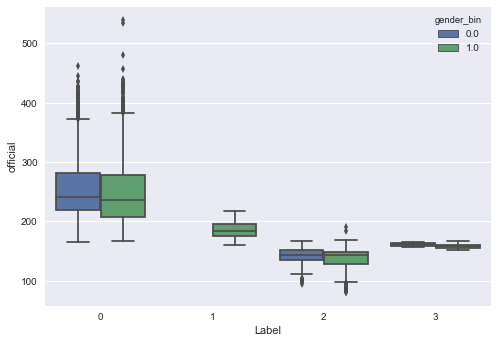

In [503]:
#What are the groups like? Let's plot average 'overall' time by group and see how it looks

#Actually, based on the counts above, the state variables DID NOT AFFECT CLUSTERING ASSIGNMENTS. Everything stayed the same.

import seaborn as sns
df['Label'] = labels
sns.boxplot(x = df['Label'], y = df['official'], hue = df['gender_bin'])

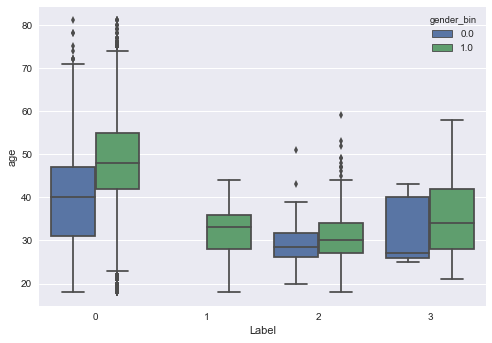

In [504]:
sns.boxplot(x = df['Label'], y = df['age'], hue = df['gender_bin'])

Trial: 1
Number of estimated clusters: 5


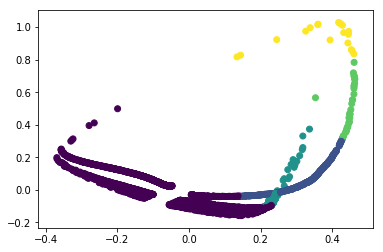

[[0, 2725], [1, 318], [2, 64], [3, 38], [4, 19]]
Silhouette Score: 0.427067693663
Trial: 2
Number of estimated clusters: 5


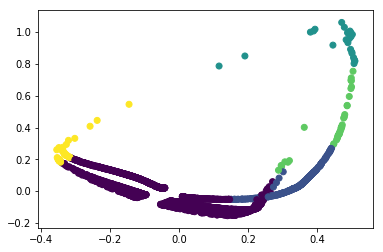

[[0, 2763], [1, 289], [2, 26], [3, 37], [4, 49]]
Silhouette Score: 0.408076244628
Trial: 3
Number of estimated clusters: 3


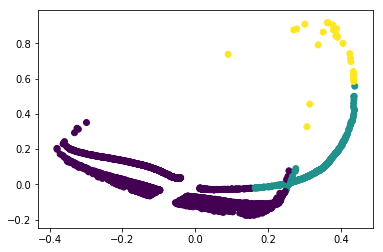

[[0, 2766], [1, 371], [2, 27]]
Silhouette Score: 0.536087830164
Trial: 4
Number of estimated clusters: 5


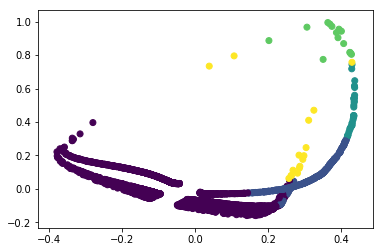

[[0, 2769], [1, 331], [2, 32], [3, 16], [4, 16]]
Silhouette Score: 0.506436816604
Average Silhouette Score: 0.469417146265


In [6]:
#Try mean-shift one last time with sample (not full dataset) so that we can test silhouette coefficient. We will compare to the
#silhouette coefficient of other algorithms later.


sil = []
#Run 5 tests on 10% samples to see how the clusters differ from sample to sample, and to see how consistent silhouette scores are
#Remove the seed from the train-test split to allow for randomness

for i in range(4):

    df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\boston_marathon_results.csv')

#Binarize gender. Assign numbers to countries. Remove name, bib, state, city, country
    df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
    df = df.drop(['name', 'bib', 'ctz', 'state', 'city', 'country', 'gender'], axis = 1)

#Some runners have a '-' for certain fields. Replace with np.nan and drop them
    for col in range(len(df.columns)):
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: str(x).strip()).replace('-', np.nan)
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: float(x))
    
#Drop NaNs
    df = df.dropna()

#Normalize the data for clustering
    X = normalize(df)

#We don't know how many clusters to expect.. so let's use Mean Shift clustering to begin

    from sklearn.model_selection import train_test_split

#Divide into training and test sets.
    X_train, X_test = train_test_split(
        X,
        test_size=0.9)


##Trial #2 - let's just use the whole sample to train

#X_train = X

    from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X_train, quantile=0.2)

# Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_train)

# Extract cluster assignments for each data point.
    labels = ms.labels_

# Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

# Count our clusters.
    n_clusters_ = len(np.unique(labels))
    print("Trial:", i+1)
    print("Number of estimated clusters: {}".format(n_clusters_))

    X_traindf = pd.DataFrame(X_train)

#Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

# Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

#Append Labels to the PCA reduced dataset
    X_pca['Labels'] = labels

#Plot
    plt.scatter(X_pca[0], X_pca[1], c = labels)
    plt.show()

    import itertools
    c = list(itertools.product(labels))
    counts = [[x, c.count(x)] for x in set(labels)]
    print(counts)
    
    print("Silhouette Score:", metrics.silhouette_score(X_train, labels, metric='euclidean'))
    sil.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
print("Average Silhouette Score:", np.mean(sil))

In [ ]:
#Some aspects of the clusters are consistent, some are not. The number of clusters identified ranged from 3 to 5 and
#The silhouette score ranged from 40% to 54% with an average of 47%

#Lets see how the other algorithms compare.

Number of estimated clusters: 50


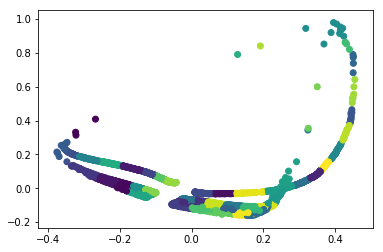

[[0, 3], [1, 95], [2, 37], [3, 84], [4, 82], [5, 86], [6, 99], [7, 93], [8, 46], [9, 135], [10, 76], [11, 173], [12, 33], [13, 13], [14, 14], [15, 54], [16, 5], [17, 56], [18, 60], [19, 209], [20, 50], [21, 1], [22, 54], [23, 36], [24, 11], [25, 127], [26, 30], [27, 60], [28, 14], [29, 190], [30, 87], [31, 1], [32, 46], [33, 59], [34, 4], [35, 73], [36, 96], [37, 40], [38, 1], [39, 1], [40, 182], [41, 229], [42, 7], [43, 1], [44, 17], [45, 73], [46, 88], [47, 28], [48, 55], [49, 50]]
Silhouette Score: 0.504962303747
Number of estimated clusters: 45


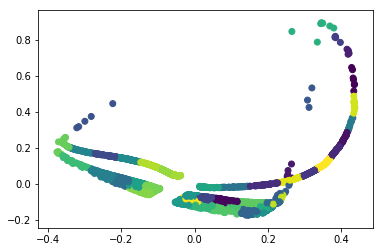

[[0, 7], [1, 80], [2, 24], [3, 6], [4, 4], [5, 61], [6, 38], [7, 54], [8, 4], [9, 95], [10, 70], [11, 5], [12, 3], [13, 14], [14, 46], [15, 63], [16, 95], [17, 45], [18, 13], [19, 69], [20, 51], [21, 91], [22, 39], [23, 212], [24, 129], [25, 153], [26, 191], [27, 58], [28, 7], [29, 90], [30, 31], [31, 45], [32, 59], [33, 112], [34, 28], [35, 222], [36, 173], [37, 102], [38, 253], [39, 73], [40, 19], [41, 13], [42, 38], [43, 84], [44, 95]]
Silhouette Score: 0.522729558245
Number of estimated clusters: 48


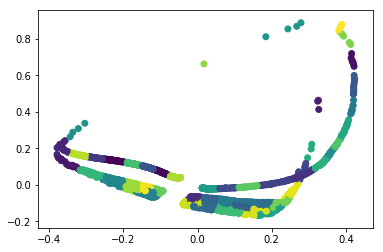

[[0, 70], [1, 91], [2, 7], [3, 17], [4, 3], [5, 35], [6, 217], [7, 66], [8, 46], [9, 44], [10, 11], [11, 43], [12, 71], [13, 13], [14, 52], [15, 114], [16, 95], [17, 95], [18, 67], [19, 9], [20, 85], [21, 169], [22, 80], [23, 51], [24, 4], [25, 4], [26, 155], [27, 69], [28, 23], [29, 3], [30, 55], [31, 35], [32, 67], [33, 89], [34, 37], [35, 26], [36, 160], [37, 72], [38, 5], [39, 1], [40, 113], [41, 291], [42, 41], [43, 134], [44, 66], [45, 34], [46, 125], [47, 4]]
Silhouette Score: 0.49736694596
Number of estimated clusters: 49


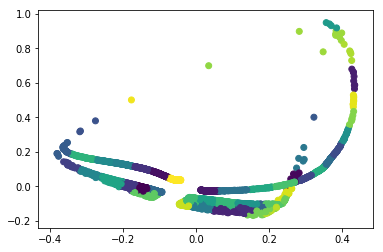

[[0, 135], [1, 12], [2, 125], [3, 156], [4, 8], [5, 64], [6, 63], [7, 95], [8, 105], [9, 26], [10, 45], [11, 37], [12, 3], [13, 1], [14, 29], [15, 66], [16, 191], [17, 76], [18, 45], [19, 5], [20, 91], [21, 86], [22, 35], [23, 52], [24, 22], [25, 74], [26, 4], [27, 104], [28, 84], [29, 34], [30, 65], [31, 58], [32, 111], [33, 224], [34, 38], [35, 63], [36, 171], [37, 27], [38, 66], [39, 7], [40, 1], [41, 8], [42, 5], [43, 39], [44, 95], [45, 16], [46, 9], [47, 1], [48, 287]]
Silhouette Score: 0.510121992634
Average Silhouette Score: 0.508795200147


In [4]:
#Try using Affinity Propogation Next (dataset with no categorical vars)


sil = []
#Run 5 tests on 10% samples to see how the clusters differ from sample to sample, and to see how consistent silhouette scores are
#Remove the seed from the train-test split to allow for randomness

for i in range(4):

    df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\boston_marathon_results.csv')

    #Binarize gender. Assign numbers to countries. Remove name, bib, state, city, country
    df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
    df = df.drop(['name', 'bib', 'ctz', 'state', 'city', 'country', 'gender'], axis = 1)

    #Some runners have a '-' for certain fields. Replace with np.nan and drop them
    for col in range(len(df.columns)):
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: str(x).strip()).replace('-', np.nan)
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: float(x))

    #Drop NaNs
    df = df.dropna()

    #Normalize the data for clustering
    X = normalize(df)

    #Mean-shift found 4 clusters. Let's see how affinity propagation handles this problem

    from sklearn.model_selection import train_test_split

    #Running alg on whole dataset failed. Divide into training and test sets.
    X_train, X_test = train_test_split(
        X,
        test_size=0.90)


    ##Trial #2 - let's just use the whole sample to train

    #X_train = X

    from sklearn.cluster import AffinityPropagation

    # Declare and fit the model.
    af = AffinityPropagation(damping = 0.90).fit(X_train)

    # Extract cluster assignments for each data point.
    labels = af.labels_

    # Coordinates of the cluster centers.
    cluster_centers_indices = af.cluster_centers_indices_

    # Count our clusters.
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))

    X_traindf = pd.DataFrame(X_train)

    #Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

    # Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

    #Append Labels to the PCA reduced dataset
    X_pca['Labels'] = labels

#Plot
    plt.scatter(X_pca[0], X_pca[1], c = labels)
    plt.show()

    import itertools
    c = list(itertools.product(labels))
    counts = [[x, c.count(x)] for x in set(labels)]
    print(counts)
    
    print("Silhouette Score:", metrics.silhouette_score(X_train, labels, metric='euclidean'))
    sil.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
print("Average Silhouette Score:", np.mean(sil))

In [ ]:
#Affinity propagation finds 45-50 clusters even with damping set to 0.9. Higher values result in the algorithm condensing 
#to 1 single cluster...

#The silhouette scores were a bit more consistent (50-52%) and slightly higher overall than what we found with mean-shift.

#However, 45-50 clusters may not make much intuitive sense when thinking about how many different types of runners we 
#might have in the Boston Marathon. Then again, it could... age/gender buckets, along with speed.. you could maybe
#define 50 clusters that make sense. 

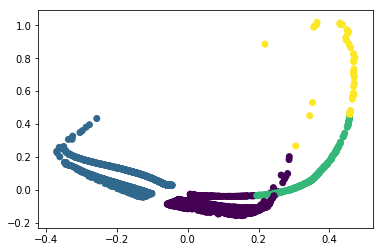

[[0, 1412], [1, 1399], [2, 311], [3, 42]]
Silhouette Score: 0.497809010269


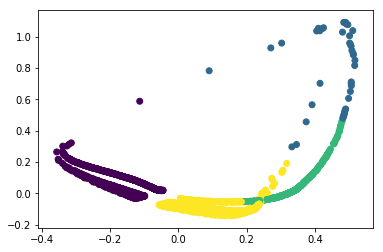

[[0, 1402], [1, 43], [2, 282], [3, 1437]]
Silhouette Score: 0.496513540965


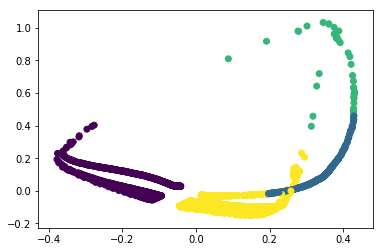

[[0, 1406], [1, 296], [2, 37], [3, 1425]]
Silhouette Score: 0.493151855576


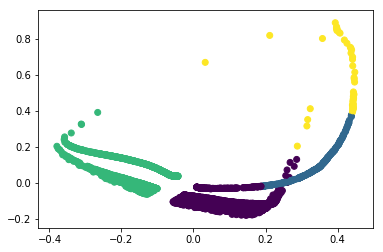

[[0, 1406], [1, 324], [2, 1385], [3, 49]]
Silhouette Score: 0.494644710007
Average Silhouette Score: 0.495529779204


In [5]:
#Let's try this multi-test approach with K-means
#Running alg on whole dataset failed. Divide into training and test sets.

#Let's also use 4 clusters, which is what we found in our first mean-shift test using the full dataset.

sil = []
#Run 5 tests on 10% samples to see how the clusters differ from sample to sample, and to see how consistent silhouette scores are
#Remove the seed from the train-test split to allow for randomness

for i in range(4):

    X_train, X_test = train_test_split(
        X,
        test_size=0.90)

    from sklearn.cluster import KMeans

    #X_train still represents only 10% of the data right now

    km = KMeans(n_clusters = 4, init = 'k-means++').fit(X_train)
    labels = km.labels_


    X_traindf = pd.DataFrame(X_train)

    #Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

    # Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

    #Append Labels to the PCA reduced dataset
    X_pca['Labels'] = labels

#Plot
    plt.scatter(X_pca[0], X_pca[1], c = labels)
    plt.show()

    import itertools
    c = list(itertools.product(labels))
    counts = [[x, c.count(x)] for x in set(labels)]
    print(counts)
    
    print("Silhouette Score:", metrics.silhouette_score(X_train, labels, metric='euclidean'))
    sil.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
print("Average Silhouette Score:", np.mean(sil))

In [315]:
#After running KMeans several times, the solution is stable even on a 10% sample. The 
#groups are similar but not identical to the groups identified by Mean-shift

#However, we can probably conclude that K-means is a better performer for this dataset, since the silhouette scores
#were extremely stable between 49% and 50%, and we don't have to deal with 45-50 clusters like we did with affinity prop

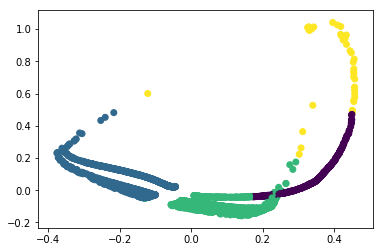

[[0, 337], [1, 1411], [2, 1377], [3, 39]]
Silhouette Score: 0.493867078027


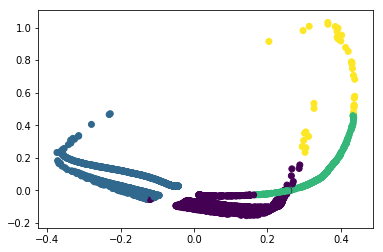

[[0, 1365], [1, 1434], [2, 325], [3, 40]]
Silhouette Score: 0.493146760265


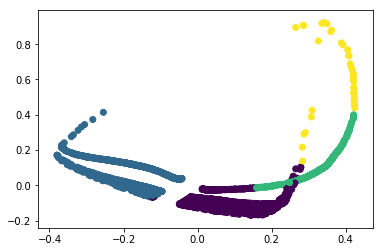

[[0, 1384], [1, 1410], [2, 329], [3, 41]]
Silhouette Score: 0.495036709527


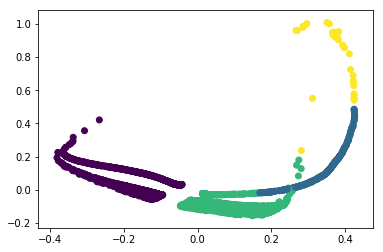

[[0, 1414], [1, 314], [2, 1405], [3, 31]]
Silhouette Score: 0.495381757888
Average Silhouette Score: 0.494358076427


In [7]:
#Lastly, let's try spectral clustering
sil = []
#Run 4 tests on 10% samples to see how the clusters differ from sample to sample, and to see how consistent silhouette scores are
#Remove the seed from the train-test split to allow for randomness

for i in range(4):

    X_train, X_test = train_test_split(
        X,
        test_size=0.90)

    from sklearn.cluster import SpectralClustering

    sc = SpectralClustering(n_clusters = 4).fit(X_train)
    labels = sc.labels_

    X_traindf = pd.DataFrame(X_train)

    #Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

    # Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca = pd.DataFrame(pca.fit_transform(X_traindf))

    #Append Labels to the PCA reduced dataset
    X_pca['Labels'] = labels

#Plot
    plt.scatter(X_pca[0], X_pca[1], c = labels)
    plt.show()

    import itertools
    c = list(itertools.product(labels))
    counts = [[x, c.count(x)] for x in set(labels)]
    print(counts)
    
    print("Silhouette Score:", metrics.silhouette_score(X_train, labels, metric='euclidean'))
    sil.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
print("Average Silhouette Score:", np.mean(sil))

In [ ]:
#Spectral analysis gave us back almost the same exact results as k-means. Both have very stable and similar 
#silhouette scores of 49%-50%, and either one could be used for this dataset.

In [ ]:
#Bonus Material

Number of estimated clusters: 8


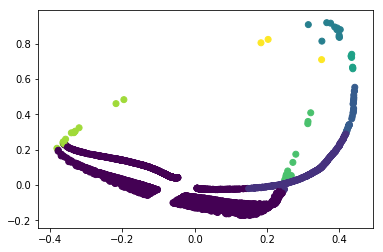

[[0, 2746], [1, 335], [2, 34], [3, 11], [4, 6], [5, 12], [6, 17], [7, 3]]
Silhouette Score: 0.422259383585
Number of estimated clusters: 6


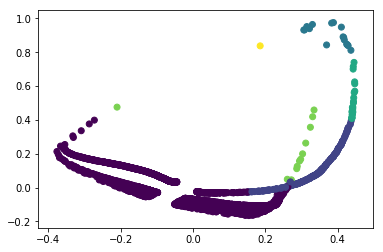

[[0, 2803], [1, 308], [2, 16], [3, 24], [4, 12], [5, 1]]
Silhouette Score: 0.530437029805
Number of estimated clusters: 7


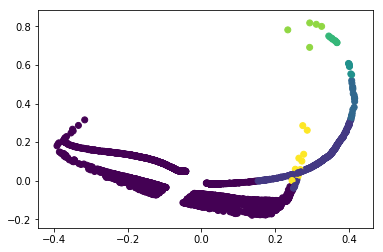

[[0, 2775], [1, 339], [2, 19], [3, 7], [4, 8], [5, 5], [6, 11]]
Silhouette Score: 0.510228280668
Number of estimated clusters: 9


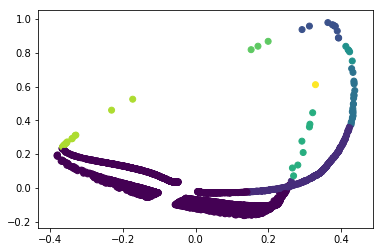

[[0, 2766], [1, 334], [2, 10], [3, 21], [4, 5], [5, 8], [6, 3], [7, 16], [8, 1]]
Silhouette Score: 0.430265729471
Average Silhouette Score: 0.473297605882


In [9]:
#Let's try mean-shift again on a PCA reduced sample before clustering and see what we get
sil = []
#Run 4 tests on 10% samples to see how the clusters differ from sample to sample, and to see how consistent silhouette scores are
#Remove the seed from the train-test split to allow for randomness

for i in range(4):
    
    X_train, X_test = train_test_split(
    X,
    test_size=0.90)

    df = pd.read_csv('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\boston_marathon_results.csv')

    #Binarize gender. Assign numbers to countries. Remove name, bib, state, city, country
    df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)
    df = df.drop(['name', 'bib', 'ctz', 'state', 'city', 'country', 'gender'], axis = 1)

    #Some runners have a '-' for certain fields. Replace with np.nan and drop them
    for col in range(len(df.columns)):
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: str(x).strip()).replace('-', np.nan)
        df[df.columns[col]] = df[df.columns[col]].apply(lambda x: float(x))

    #Drop NaNs
    df = df.dropna()

    #Normalize the data for clustering
    X = normalize(df)

    #We don't know how many clusters to expect.. so let's use Mean Shift clustering to begin

    #let's just use the whole sample to train

    #X_train = X
    X_traindf = pd.DataFrame(X_train)

    # REDUCE DIMENSIONALITY FIRST 
    pca = PCA(n_components=5)
    X_pca1 = pca.fit_transform(X_traindf)

    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(X_pca1, quantile=0.2)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_pca1)

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    # Count our clusters.
    n_clusters_ = len(np.unique(labels))

    print("Number of estimated clusters: {}".format(n_clusters_))

    #Let's just experiment and reduce the DF to 2 dimensions and see how the labels do at separating based on those two dimensions

    # Create the two-feature PCA for graphing purposes.
    pca = PCA(n_components=2)
    X_pca2 = pd.DataFrame(pca.fit_transform(X_pca1))

    #Append Labels to the PCA reduced dataset
    X_pca2['Labels'] = labels

#Plot
    plt.scatter(X_pca2[0], X_pca2[1], c = labels)
    plt.show()

    import itertools
    c = list(itertools.product(labels))
    counts = [[x, c.count(x)] for x in set(labels)]
    print(counts)
    
    print("Silhouette Score:", metrics.silhouette_score(X_train, labels, metric='euclidean'))
    sil.append(metrics.silhouette_score(X_train, labels, metric='euclidean'))
    
print("Average Silhouette Score:", np.mean(sil))

In [11]:
#So, not the most stable. 6-9 clusters, silhouette scores varying from 42-53%. Using PCA to shrink the feature-set before
#Clustering did not improve the stability of the clusters in this case.